In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

In [2]:
def rsi_14_strategy(data):
    data = data.copy() 
    data['Change'] = data['Close'].diff()

    data['Gain'] = data['Change'].where(data['Change'] > 0, 0)
    data['Loss'] = -data['Change'].where(data['Change'] < 0, 0)
    
    data['Average Gain'] = np.where(data.index < data.index[14], data['Gain'].rolling(window=14).mean(), np.nan)
    data['Average Loss'] = np.where(data.index < data.index[14], data['Loss'].rolling(window=14).mean(), np.nan)

    for i in range(14, len(data)):
        data['Average Gain'].iloc[i] = (data['Average Gain'].iloc[i-1] * 13 + data['Gain'].iloc[i]) / 14
        data['Average Loss'].iloc[i] = (data['Average Loss'].iloc[i-1] * 13 + data['Loss'].iloc[i]) / 14

    data['RS'] = data['Average Gain'] / data['Average Loss']

    data['RSI'] = (100 - (100/(1+data['RS'])))
    data['RSI_action'] = np.where(data['RSI'] < 50, 1, np.where(data['RSI'] >= 50, -1,0))

    return data[['RSI','RSI_action']]


In [3]:
def ema(data, window):
    data = data.copy()
    
    first_valid_index = data['Close'].first_valid_index()
    if first_valid_index is not None:
        initial_sma_position = data.index.get_loc(first_valid_index) + window - 1
        if initial_sma_position < len(data):
            initial_sma = data['Close'].rolling(window=window).mean().iloc[initial_sma_position]
        else:
            initial_sma = np.nan
    else:
        initial_sma = np.nan

    multiplier = (2 / (window + 1))
    
    data[f'{window}ema'] = np.nan
    
    if not np.isnan(initial_sma):
        data[f'{window}ema'].iloc[initial_sma_position] = initial_sma
    
        for i in range(initial_sma_position + 1, len(data)):
            data[f'{window}ema'].iloc[i] = (data['Close'].iloc[i] - data[f'{window}ema'].iloc[i-1]) * multiplier + data[f'{window}ema'].iloc[i-1]
    
    return data[[f'{window}ema']]


In [4]:
def ema_strategy(data):
    data = data.copy()
    ema_line = ema(data,9).copy()
        
    conditions = [
        (data['Close'] > ema_line['9ema']) & (data['Close'].notna()) & (ema_line['9ema'].notna()),
        (data['Close'] < ema_line['9ema']) & (data['Close'].notna()) & (ema_line['9ema'].notna())
    ]

    choices = [1, -1]

    data['ema_strategy_action'] = np.select(conditions, choices, default=0)

    return data[['ema_strategy_action']]

In [5]:
def macd_strategy(data):
    data = data.copy()

    fastMA = ema(data, 12)
    slowMA = ema(data, 26)
    data['macd'] = fastMA['12ema'] - slowMA['26ema']

    data['macd_action'] = np.where(data['macd'] < 0, -1, np.where(data['macd'] > 0, 1,0))

    signal_data = data[['macd']].rename(columns={'macd': 'Close'})
    signal_line = ema(signal_data, 9)

    data['signal_line'] = signal_line['9ema']
    data['macd_strategy_action'] = np.where(data['macd'] > data['signal_line'], 1, np.where(data['macd'] < data['signal_line'], -1,0))
    
    return data[['macd','macd_action','signal_line','macd_strategy_action']]


In [6]:
def log_return_buy_hold(data):
    data = data.copy()
    data['log_return_buy_hold'] = np.log(data.Close / data.Close.shift())

    return data[['log_return_buy_hold']]

In [7]:
def data_consolidation(tickers): #tickers in a list
    all_results = {}

    for ticker in tickers:
        data = yf.download(ticker, start='2010-01-01',)[['Close']]
        results = data.copy()

        ema_9 = ema(data, 9)
        ema_strat = ema_strategy(data)
        macd_strat = macd_strategy(data)
        rsi_strat = rsi_14_strategy(data)
        log_return_hold_strat = log_return_buy_hold(data)

        log_return_ema_strategy = (ema_strat['ema_strategy_action'] * log_return_hold_strat['log_return_buy_hold']).to_frame('log_return_ema_strategy')
        log_return_macd_strategy = (macd_strat['macd_strategy_action'] * log_return_hold_strat['log_return_buy_hold']).to_frame('log_return_macd_strategy')
        log_return_rsi_strategy = (rsi_strat['RSI_action'] * log_return_hold_strat['log_return_buy_hold']).to_frame('log_return_rsi_strategy')

        results = results.join([ema_9, ema_strat, macd_strat, rsi_strat, log_return_hold_strat, log_return_ema_strategy, log_return_macd_strategy, log_return_rsi_strategy])
        all_results[ticker] = results

    all_results_df = pd.concat(all_results, axis=1)
    all_results_df.dropna(inplace=True)
    
    return all_results_df


In [8]:
tickers = ['AAPL', 'GOOG', 'LMT', 'NFLX']
df = data_consolidation(tickers)
print(df.shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
(3440, 52)


In [9]:
ticker_to_look = "AAPL"
stock = df[ticker_to_look]

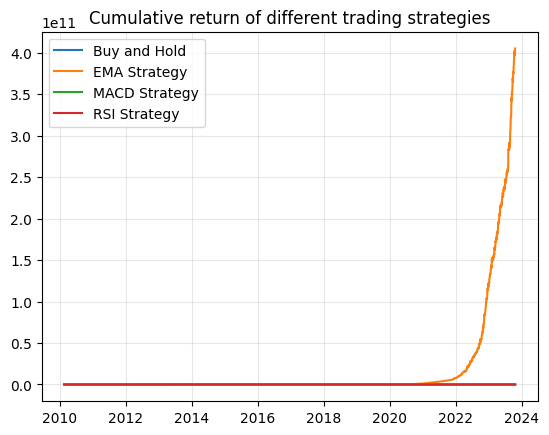

In [18]:
plt.plot(np.exp(stock['log_return_buy_hold']).cumprod(), label='Buy and Hold')
plt.plot(np.exp(stock['log_return_ema_strategy']).cumprod(), label="EMA Strategy")
plt.plot(np.exp(stock['log_return_macd_strategy']).cumprod(), label = "MACD Strategy")
plt.plot(np.exp(stock['log_return_rsi_strategy']).cumprod(), label = "RSI Strategy")
plt.legend(loc=2)
plt.title("Cumulative return of different trading strategies")
plt.grid(True, alpha=.3)